## Advanced Dimensionality Reduction: POD and DMD

#### Misael M. Morales
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize

from sklearn.decomposition import PCA

***
### Proper Orthogonal Decomposition
Dynamic Mode Decomposition (DMD) is based on proper orthogonal decomposition and provides spatial and temporal model decomposition. Please load the attached dataset *X_t.npy* and *X_t1.npy*. You will find a matrix $X$ of dimension $89,351 \times 150$ where each column represents the snapshot of a flow field (of dimension $449\times199$) over time in *X_t.npy* and a matrix $X'$ of dimension $89,351\times150$ in *X_t1.npy* where each column in $X'$ is the next state of each column in $X$.

X_t shape:(89351, 150) | X_t+1 shape:(89351, 150)


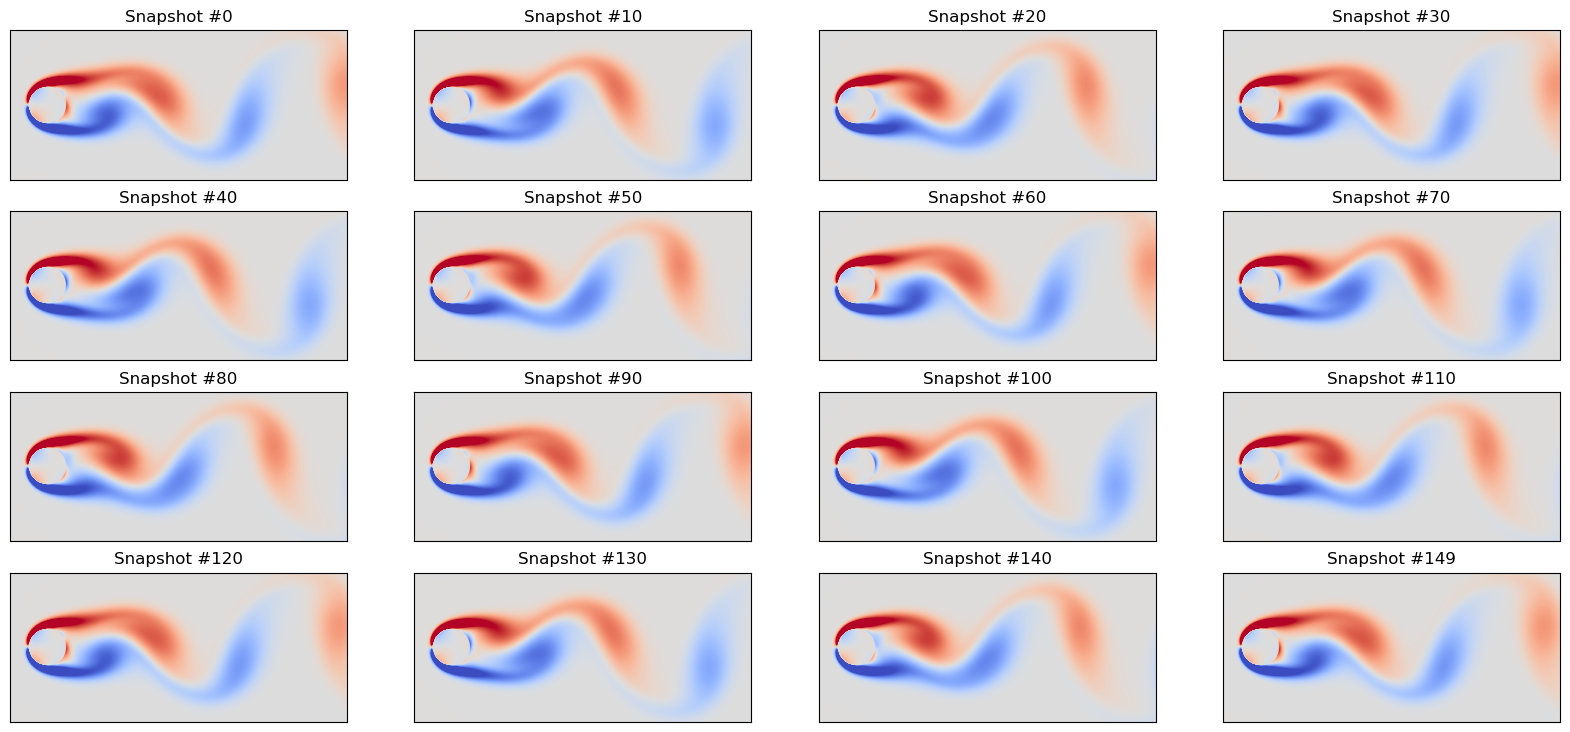

In [3]:
Xt  = np.load("data/X_t.npy")
Xt1 = np.load("data/X_t1.npy") 
print("X_t shape:{} | X_t+1 shape:{}".format(Xt.shape, Xt1.shape))

dim1, dim2 = 449, 199; colmap = 'coolwarm'

fig = plt.figure(figsize=(20,9))
for k in range(15):
    plt.subplot(4,4,k+1)
    plt.imshow(Xt[:,k*10].reshape(dim1,dim2).T, vmin=-3, vmax=3, cmap=colmap)
    plt.xticks([]); plt.yticks([])
    plt.title('Snapshot #{}'.format(k*10))
plt.subplot(4,4,16)
plt.imshow(Xt[:,149].reshape(dim1,dim2).T, vmin=-3, vmax=3, cmap=colmap)
plt.xticks([]); plt.yticks([])
plt.title('Snapshot #{}'.format(149))
plt.show();

Step 1: Compute the SVD of matrix $X$ and select a suitable number of SVD basis to retain. Plot the first 4 basis.

Shapes:
U=(89351, 150) | S=(150, 150) | Vt=(150, 150)


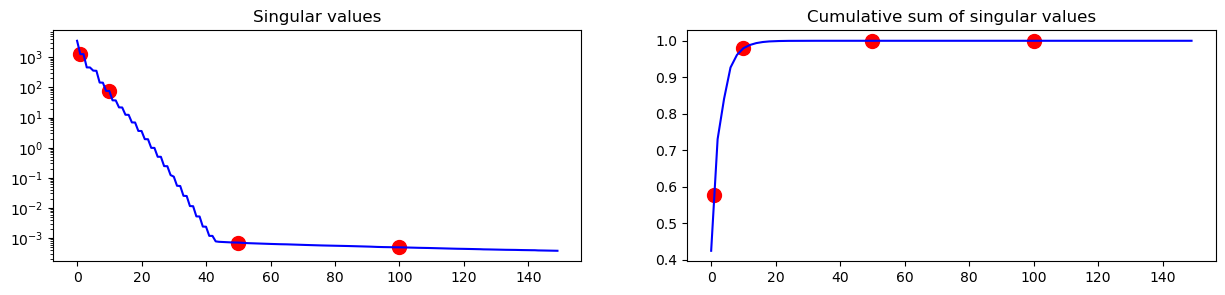

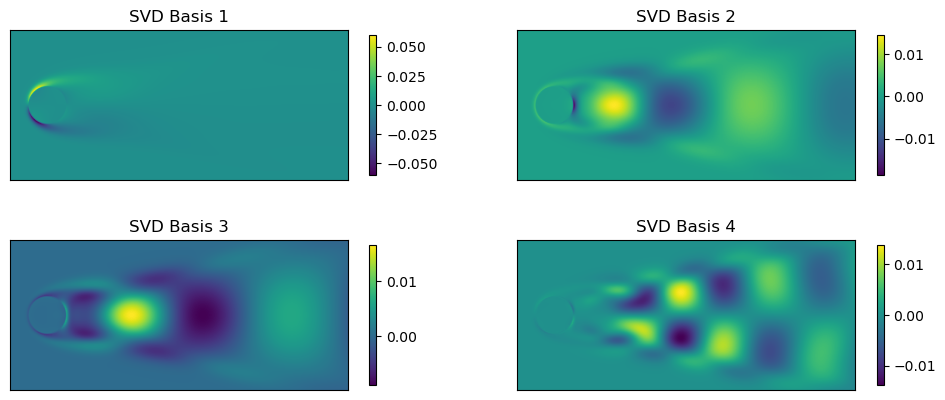

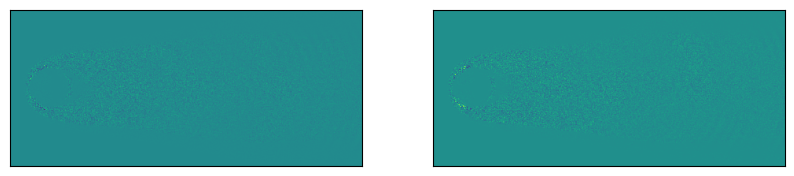

In [6]:
U, S, Vt = np.linalg.svd(Xt, full_matrices=False)
S = np.diag(S)
print('Shapes:\nU={}'.format(U.shape), '| S={}'.format(S.shape) ,'| Vt={}'.format(Vt.shape))

#get the singular values and cumulative energy
ks = [1, 10, 50, 100]

plt.figure(figsize=(15, 3))
S_ = np.diag(S)
plt.subplot(1, 2, 1)
plt.semilogy(S_, c='b')
plt.scatter(ks, S_[ks], s=100, c='r') #approx
plt.title('Singular values')

S_ = np.cumsum(np.diag(S))/np.sum(np.diag(S))
plt.subplot(1, 2, 2)
plt.plot(S_, c='b')
plt.scatter(ks, S_[ks], s=100, c='r') #approx
plt.title('Cumulative sum of singular values')
plt.show()

fig = plt.figure(figsize=(12,5))
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.imshow(U[:,k].reshape(dim1,dim2).T)
    plt.xticks([]); plt.yticks([])
    plt.title('SVD Basis {}'.format(k+1))
    plt.colorbar(shrink=0.8)
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(U[:,148].reshape(dim1,dim2).T)
plt.xticks([]); plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(U[:,149].reshape(dim1,dim2).T)
plt.xticks([]); plt.yticks([])
plt.show()

A best fit linear operator,  $A$, relates $X$ and $X'$ such that $X\approx AX'$. Find $A$ using your results in (b) such that $X'=\tilde{A}X$. Plot the $\tilde{A}$ as an image.

Recall: $A=X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}^{*}$
However, we are only interested in the leading r eigenvalues and eigenvectors of A,
and we may thus project A onto the POD modes in U.
Now: $\tilde{A} = \tilde{U}^* A \tilde{U} = \tilde{U}^* X' \tilde{V} \tilde{\Sigma}^{-1}$
And with that, we have that: $\tilde{x}_{k+1} = \tilde{A} \tilde{x}_k$.

Shapes:
U_=(89351, 40) | S_=(40, 40) | Vt_=(40, 40)


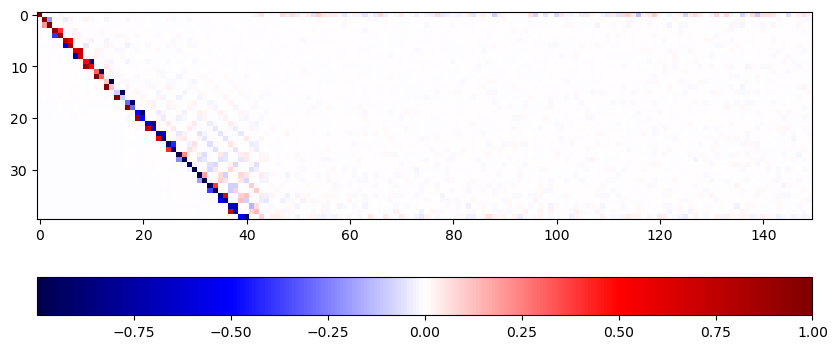

In [8]:
U_, S_, Vt_  = U[:, :40], S[:40, :40], Vt[:40, :40]
print('Shapes:\nU_={}'.format(U_.shape), 
      '| S_={}'.format(S_.shape) ,'| Vt_={}'.format(Vt_.shape))

A_ = U_.T @ Xt1 @ Vt.T @ np.linalg.inv(S)

plt.figure(figsize=(10,5))
plt.imshow(A_, 'seismic')
plt.colorbar(orientation='horizontal')
plt.show();

Step 3: Calculate the spectral decomposition of $\tilde{A}$ and plot only the real values as an image.

The spectral decomposition of $\tilde{A}$ is computed: $\tilde{A}W=W\Lambda$.

The entries of the diagonal matrix $\Lambda$ are the DMD eigenvalues, which also correspond to eigenvalues of the full $A$ matrix. The columns of $W$ are eigenvectors of $\tilde{A}$, and provide a coordinate transformation that diagonalizes the matrix. These columns may be thought of as linear combinations of POD mode amplitudes that behave linearly with a single temporal pattern given by $\lambda$.

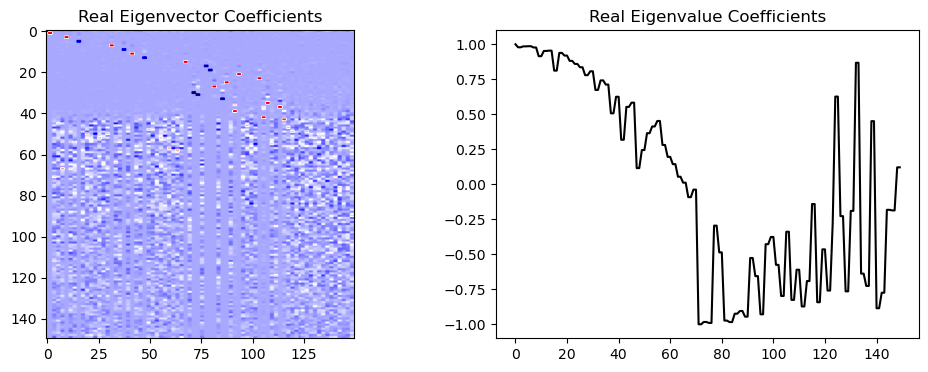

In [9]:
A_ = U.T @ Xt1 @ Vt.T @ np.linalg.inv(S)
eigvals, eigvecs = np.linalg.eig(A_)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(eigvecs.real, cmap='seismic')
plt.title('Real Eigenvector Coefficients')

plt.subplot(1,2,2)
plt.plot(eigvals.real, 'k')
plt.title('Real Eigenvalue Coefficients')
plt.show();

Step 4: Calculate the DMD modes and plot the first 4 DMD modes. What do you observe?

The high-dimensional DMD modes $\Phi$ are reconstructed using the eigenvectors $W$ of the reduced system and the time-shifted snapshot matrix $X'$ according to:
$\Phi = X' \tilde{V} \tilde{\Sigma}^{-1} W$.
Remarkably, these DMD modes are eigenvectors of the high-dimensional $A$ matrix corresponding to the eigenvalues in $\Lambda$, as shown:
$A\Phi = (X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{U}^*)(X' \tilde{V} \tilde{\Sigma}^{-1} W) = X' \tilde{V} \tilde{\Sigma}^{-1} \tilde{A} W = X' \tilde{V} \tilde{\Sigma}^{-1} W \Lambda = \Phi \Lambda$

Phi shape (89351, 150)


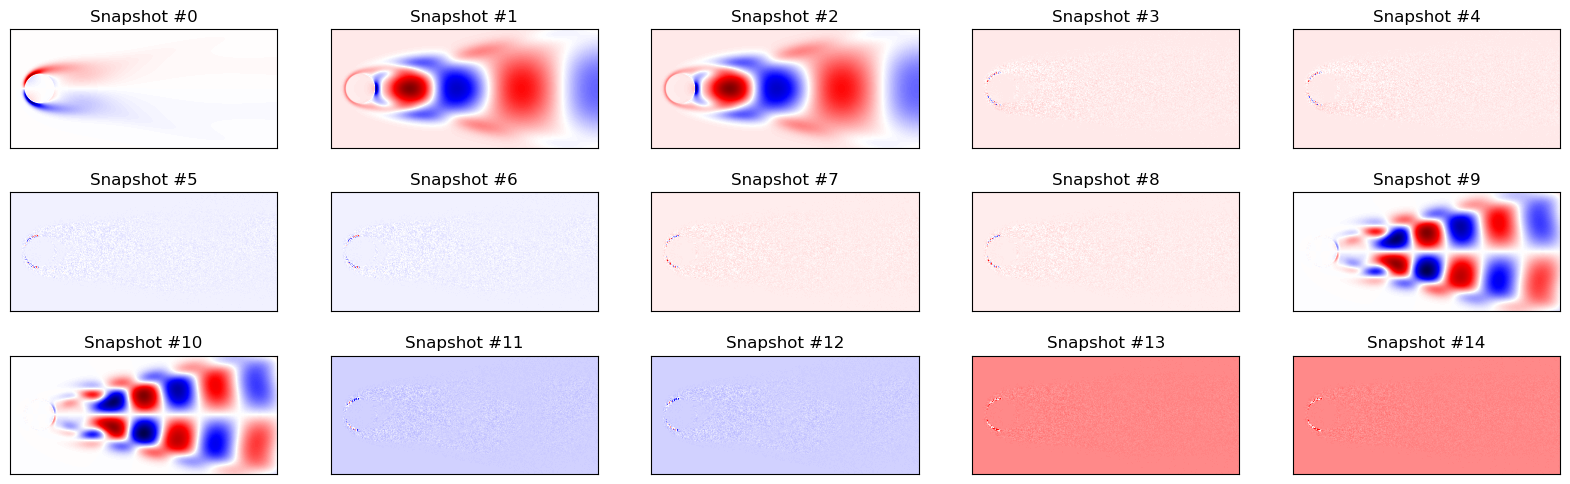

In [10]:
phi = Xt1 @ Vt.T @ np.linalg.inv(S) @ eigvecs.real
print('Phi shape {}'.format(phi.shape))

fig = plt.figure(figsize=(20,6))
for k in range(15):
    plt.subplot(3,5,k+1)
    plt.imshow(phi[:,k].reshape(dim1,dim2).T, 'seismic')
    plt.xticks([]); plt.yticks([])
    plt.title('Snapshot #{}'.format(k))

***

### About Me

I am currently a PhD student in Petroleum & Geosystems Engineering at The University of Texas at Austin, and I am supervised by Drs. Pyrcz and Torres-Verdin. My background is in Petroleum Engineering & Applied Mathematics from the University of Tulsa. I am originally from Venezuela!

At UT, I am working on the computational description of subsurface energy and environmental systems. I combine domain-specific knowledge with tools from machine learning & deep learning, math and statistics, for accurate characterization and forecasting of complex dynamical systems in the subsurface. My work is centered on integrated applied energy data analytics by developing novel technologies, practical workflows, demos and documentation to support the digital revolution in energy. My focus is on machine learning and data science applications for subsurface modeling and simulation, including: uncertainty quantification, inverse modeling, data assimilation, control & optimization, and physics-informed predictive analytics.


* More workflows to come on other advanced dimensionality reduction techniques!
    * PCA/kPCA, SVD, Dictionary Learning, tSNE, DFT/DCT/DWT, POD/DMD, Deep Learning-based AutoEncoders, ... 
* Also working on subsurface problems including machine learning & data science applications for reservoir modeling & simulation.
    * Uncertainty quantification, data assimilation, control & optimizaiton, inverse & reduced-order modeling! 

I hope this was helpful,

**Misael M. Morales**
#### [GitHub](https://github.com/misaelmmorales) | [Website](https://sites.google.com/view/misaelmmorales) | [LinkedIn](https://www.linkedin.com/in/misaelmmorales)

# END